1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


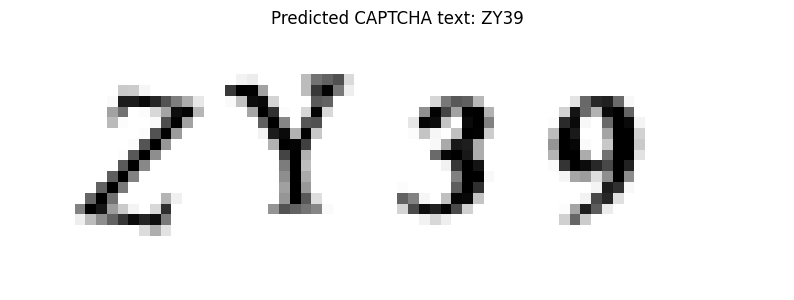

Predicted CAPTCHA text: ZY39


In [11]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import pickle
import matplotlib.pyplot as plt

# Load the pre-trained model
model = load_model("captcha_model.h5")

# Load the label binarizer (the mapping from labels to characters)
with open("model_labels.dat", "rb") as f:
    char_to_label = pickle.load(f)

# Reverse the char_to_label dictionary to map indices back to characters
label_to_char = {v: k for k, v in char_to_label.items()}

def preprocess_image(image_path):
    """
    Preprocesses a new CAPTCHA image for prediction.
    """
    # Load the image and convert it to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Add extra padding around the image
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    
    # Threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    # Find contours in the image
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    letter_image_regions = []
    # Loop through each contour and extract the letter inside
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        # Split wide contours (conjoined letters) into two regions
        if w / h > 1.25:
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            letter_image_regions.append((x, y, w, h))
    
    # Sort the detected letter images from left-to-right
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    
    # Extract each letter as an individual image and preprocess it for the model
    letter_images = []
    for letter_bounding_box in letter_image_regions:
        x, y, w, h = letter_bounding_box
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]
        # Resize the letter image to 20x20 pixels (model input size)
        letter_image_resized = cv2.resize(letter_image, (20, 20))
        # Normalize the pixel values to [0, 1]
        letter_image_resized = letter_image_resized.astype("float32") / 255.0
        # Reshape for the CNN model
        letter_images.append(letter_image_resized.reshape((20, 20, 1)))
    
    return np.array(letter_images), image

def predict_captcha(image_path):
    """
    Predicts the text in a CAPTCHA image and displays the image.
    """
    letter_images, original_image = preprocess_image(image_path)
    
    # Make predictions using the model
    predictions = model.predict(letter_images)
    
    # Convert predictions to characters
    predicted_text = ''.join([label_to_char[np.argmax(pred)] for pred in predictions])
    
    # Display the original image with prediction
    # Convert BGR to RGB for matplotlib
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(original_image_rgb)
    plt.title(f'Predicted CAPTCHA text: {predicted_text}')
    plt.axis('off')
    plt.show()
    
    return predicted_text

# Example usage
image_path = r"C:\Users\adars\Downloads\CAPTCHA\ZY39.png"
predicted_text = predict_captcha(image_path)
print(f"Predicted CAPTCHA text: {predicted_text}")